Members: 
- Manuela 
- Lucresse
- Likhita
- Gil-Allen
- Regis
- Lionel

# IMAGE CLASSIFICATION

In this notebook, we will classify emotions through facial images. The emotions that are labels are Anger, Disgust, Fear, Happy, Sad, Surprise, Neutral. To achieve our goal, we have a dataset of images in csv named fer2013. We download it in kaggle. and we will use CNN.

In [17]:
import tensorflow as tf

import keras
from keras.models import Sequential, model_from_json
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Dense, Activation, Dropout, Flatten, Normalization
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, multilabel_confusion_matrix
from keras.optimizers import *
from keras.layers import BatchNormalization
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split


# Get the data

In [2]:
filname = 'fer2013.csv'
label_map = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
names=['emotion','pixels','usage']
df=pd.read_csv('fer2013.csv',names=names, na_filter=False)
im=df['pixels']
df.head(10)

,emotion,pixels,usage
0,emotion,pixels,Usage
1,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
2,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
3,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
4,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
5,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
6,2,55 55 55 55 55 54 60 68 54 85 151 163 170 179 ...,Training
7,4,20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...,Training
8,3,77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...,Training
9,3,85 84 90 121 101 102 133 153 153 169 177 189 1...,Training


In [3]:
usage=df['usage'].value_counts()
usage

usage
Training       28709
PublicTest      3589
PrivateTest     3589
Usage              1
Name: count, dtype: int64

In [4]:
def getData(filname):
    # images are 48x48
    # N = 35887
    Y = []
    X = []
    first = True
    for line in open(filname):
        if first:
            first = False
        else:
            row = line.split(',')
            Y.append(int(row[0]))
            X.append([int(p) for p in row[1].split()])

    X, Y = np.array(X) / 255.0, np.array(Y)
    return X, Y

In [5]:
X, Y = getData(filname)
num_class = len(set(Y))
print(num_class)

7


In [6]:
# we need to reshape images 
N, D = X.shape
X = X.reshape(N, 48, 48, 1)

In [7]:
#We split the dataset in train (80%) and test (20%) to avoid overfitting

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
y_train = (np.arange(num_class) == y_train[:, None]).astype(np.float32)
y_test = (np.arange(num_class) == y_test[:, None]).astype(np.float32)

Build the model

In [8]:
def my_model():
    model = Sequential()
    input_shape = (48,48,1)
    model.add(Conv2D(64, (5, 5), input_shape=input_shape,activation='relu', padding='same'))
    model.add(Conv2D(64, (5, 5), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, (5, 5),activation='relu',padding='same'))
    model.add(Conv2D(128, (5, 5),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(256, (3, 3),activation='relu',padding='same'))
    model.add(Conv2D(256, (3, 3),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(7))
    model.add(Activation('softmax'))
    
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer='adam')
    
    return model
model=my_model()
model.summary()




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        1664      
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        102464    
                                                                 
 batch_normalization (Batch  (None, 48, 48, 64)        256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 64)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 128)       204928    
                                                                 
 conv2d_3 (Conv2D)           (None, 24, 24, 128)     

# Explication du modèle

Couche d'Entrée : Elle sert de couche d'entrée avec une fonction d'activation ReLU. La spécification de l'input_shape est (48, 48, 1), indiquant que les images en entrée ont une taille de 48x48 pixels avec un seul canal (niveau de gris).

Couche Convolutionnelle et Normalisation par Lots: Il s'agit de deux couches convolutives avec 64 filtres chacune et une fonction d'activation ReLU. Entre ces deux couches, il y a une couche de normalisation par lots qui normalise les activations de la couche précédente.

Couche de Max Pooling : Une couche de max pooling avec une fenêtre de (2, 2), qui réduit la taille spatiale des activations de la couche précédente.

Couche Flatten : Cette couche transforme les activations en un vecteur plat avant de passer à la partie dense du réseau.

Couches Denses (Fully Connected) avec Normalisation par Lots et Dropout : Deux couches denses avec 128 et 7 neurones respectivement. Entre ces deux couches, il y a une couche de normalisation par lots, une fonction d'activation ReLU, et une couche de dropout pour régulariser le modèle en désactivant aléatoirement certains neurones pendant l'entraînement.

Couche de Sortie :C'est une couche dense avec 7 neurones (correspondant au nombre de classes de sortie) et une fonction d'activation softmax pour obtenir des probabilités pour chaque classe.
Compilation du Modèle : Compilation du modèle avec la fonction de perte categorical_crossentropy, l'optimiseur Adam et la métrique d'évaluation de la précision.

# TRAINING

In [9]:
path_model='model_filter.h5'
tf.keras.backend.clear_session() 
model=my_model() 
tf.keras.backend.set_value(model.optimizer.lr,1e-3) 
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
h=model.fit(x=X_train,     
            y=y_train, 
            batch_size=69, 
            epochs=30, 
            verbose=1, 
            validation_data=(X_test,y_test),
            shuffle=True,
            callbacks=[
                ModelCheckpoint(filepath=path_model),
                early_stopping
            ]
            )


Epoch 1/30


417/417 [==============================] - 282s 670ms/step - loss: 1.6606 - accuracy: 0.3576 - val_loss: 1.6474 - val_accuracy: 0.3709
Epoch 2/30


c:\Users\Ephrayyy\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


417/417 [==============================] - 273s 655ms/step - loss: 1.3325 - accuracy: 0.4877 - val_loss: 1.8892 - val_accuracy: 0.3782
Epoch 3/30
417/417 [==============================] - 270s 647ms/step - loss: 1.1559 - accuracy: 0.5616 - val_loss: 1.3889 - val_accuracy: 0.4858
Epoch 4/30
417/417 [==============================] - 269s 646ms/step - loss: 1.0291 - accuracy: 0.6165 - val_loss: 1.1011 - val_accuracy: 0.5932
Epoch 5/30
417/417 [==============================] - 270s 647ms/step - loss: 0.9063 - accuracy: 0.6655 - val_loss: 1.2245 - val_accuracy: 0.5581
Epoch 6/30
417/417 [==============================] - 270s 647ms/step - loss: 0.7722 - accuracy: 0.7156 - val_loss: 1.1357 - val_accuracy: 0.5890
Epoch 7/30
417/417 [==============================] - 270s 647ms/step - loss: 0.6163 - accuracy: 0.7767 - val_loss: 1.2049 - val_accuracy: 0.5894
Epoch 8/30
417/417 [==============================] - 270s 646ms/step - loss: 0.4585 - accuracy: 0.8391 - val_loss: 1.3574 - val_accura

With the Early stopping, the training will stop when the val_loss will equal 0

# MODEL EVALUATION

In [10]:
objects = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
y_pos = np.arange(len(objects))
print(y_pos)

[0 1 2 3 4 5 6]


In [27]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy:.4f}')

Test Loss: 1.1011
Test Accuracy: 0.5932


225/225 [==============================] - 21s 91ms/step


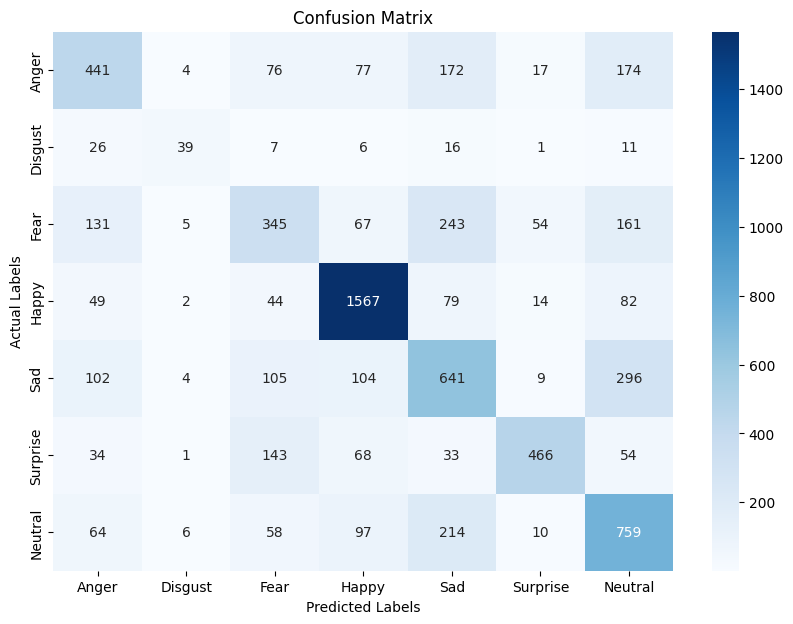

In [28]:
y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_map, yticklabels=label_map)
plt.title('Confusion Matrix')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()

In [29]:
print(classification_report(y_true, y_pred, target_names=label_map))

              precision    recall  f1-score   support

       Anger       0.52      0.46      0.49       961
     Disgust       0.64      0.37      0.47       106
        Fear       0.44      0.34      0.39      1006
       Happy       0.79      0.85      0.82      1837
         Sad       0.46      0.51      0.48      1261
    Surprise       0.82      0.58      0.68       799
     Neutral       0.49      0.63      0.55      1208

    accuracy                           0.59      7178
   macro avg       0.59      0.53      0.55      7178
weighted avg       0.60      0.59      0.59      7178



In [30]:
accuracy = accuracy_score(y_true, y_pred)
print(f'Accuracy Score: {accuracy:.4f}')

Accuracy Score: 0.5932


# CONCLUSION

The model finds it easier to identify happy faces than other emotions. Therefore, the data should be balanced for better results.